In [1]:
%pip install -U pip
%pip install -q numpy torchcodec torchaudio ffmpeg matplotlib
%pip list |awk '/numpy|torch|ffmpeg|matplotlib/ {print $1,$2}'

ERROR:root:code for hash blake2b was not found.
Traceback (most recent call last):
  File "/home/marco/.pyenv/versions/3.11.11/lib/python3.11/hashlib.py", line 307, in <module>
    globals()[__func_name] = __get_hash(__func_name)
                             ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marco/.pyenv/versions/3.11.11/lib/python3.11/hashlib.py", line 123, in __get_builtin_constructor
    raise ValueError('unsupported hash type ' + name)
ValueError: unsupported hash type blake2b
ERROR:root:code for hash blake2s was not found.
Traceback (most recent call last):
  File "/home/marco/.pyenv/versions/3.11.11/lib/python3.11/hashlib.py", line 307, in <module>
    globals()[__func_name] = __get_hash(__func_name)
                             ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marco/.pyenv/versions/3.11.11/lib/python3.11/hashlib.py", line 123, in __get_builtin_constructor
    raise ValueError('unsupported hash type ' + name)
ValueError: unsupported hash type blake2s
Note: you may need t

In [2]:
try:
    import torchaudio as ta
    import torchaudio.transforms as T
    from torch import Tensor, arange
    from torchcodec.decoders import AudioDecoder
    from torchcodec.encoders import AudioEncoder
    import matplotlib.pyplot as plt
    import numpy as np
    from pprint import pprint
except ImportError as e:
    print(f"Import error: {e}")

In [3]:
# constants and configurations
AUDIO_FILE = "2.MP3"
TARGET_SAMPLING_RATE = 16_000
TARGET_CHANNEL_NUM = 1
FREQUENCY_BINS = 512

In [4]:
# load audio file
audioClip = AudioDecoder(AUDIO_FILE)

# explore results
print(f"Returned Type: {type(audioClip)}. Metadata: {type(audioClip.metadata)}")

Returned Type: <class 'torchcodec.decoders._audio_decoder.AudioDecoder'>. Metadata: <class 'torchcodec._core._metadata.AudioStreamMetadata'>


In [5]:
# print loaded file metadata
pprint(audioClip.metadata)
pprint(audioClip.get_all_samples().data.shape)

AudioStreamMetadata:
  duration_seconds_from_header: 9.017125
  begin_stream_seconds_from_header: 0.0
  bit_rate: 128000.0
  codec: mp3
  stream_index: 0
  sample_rate: 44100
  num_channels: 2
  sample_format: fltp

torch.Size([2, 398592])


In [6]:
# resample audio to desired format
samples, sample_rate, sample_format = audioClip.get_all_samples().data, audioClip.metadata.sample_rate, audioClip.metadata.codec
encoder = AudioEncoder(samples, sample_rate=sample_rate)

# resample
resampledSamples: Tensor = encoder.to_tensor(format=sample_format, num_channels=TARGET_CHANNEL_NUM, sample_rate=TARGET_SAMPLING_RATE)

In [7]:
# verify resampling...
resampledClip = AudioDecoder(resampledSamples)

# view
pprint(resampledClip.metadata)
pprint(type(resampledClip))

AudioStreamMetadata:
  duration_seconds_from_header: 9.144
  begin_stream_seconds_from_header: 0.069062
  bit_rate: 24000.0
  codec: mp3
  stream_index: 0
  sample_rate: 16000
  num_channels: 1
  sample_format: fltp

<class 'torchcodec.decoders._audio_decoder.AudioDecoder'>


In [81]:
# plot functions
def waveform(clip: AudioDecoder, title: str = "Waveform Plot"):
    # sample rate & channels
    sr = clip.metadata.sample_rate
    channels = clip.metadata.num_channels

    # get samples
    samples = clip.get_all_samples().data
    nc, ns = samples.shape

    # check
    if nc != channels:
        print(f"Mismatch: reported channels in metadata: {channels} differ from Tensor shape: {samples.shape}")
    
    # time scale (num_samples/sample_rate)
    time_scale = arange(0, ns) / sr
    
    fig, axis = plt.subplots(nc,1)
    fig.tight_layout()
    if nc == 1:
        values = samples[0]
        axis.set_xlim([0,time_scale[-1]])
        axis.plot(time_scale, values)
        axis.set_ylabel("Amplitude")
        axis.set_xlabel("Time (s)")
    else:
        for i in range(nc):
            values = samples[i]
            axis[i].set_xlim([0,time_scale[-1]])
            axis[i].plot(time_scale, values)
            axis[i].set_ylabel("Amplitude")
            axis[i].set_xlabel("Time (s)")

    return (fig, axis)

# calculate audio spectrum
def spectrum(clip: AudioDecoder, num_fft_bins: int = FREQUENCY_BINS, title: str = "Power Spectrum"):
    # get samples
    samples = clip.get_all_samples().data
    sample_rate = clip.metadata.sample_rate
    channels = clip.metadata.num_channels

    # spectrum calculator
    s = T.Spectrogram(n_fft=num_fft_bins, power=2)

    # plot
    fig, axis = plt.subplots(channels, 1)
    if channels == 1:
        # calculate spectrum of audio samples (power over frequency)
        spectrogram = s(samples)
    
        # convert signal values to dB 
        samples_dB = T.AmplitudeToDB().forward(spectrogram)

        # plot the spectrogram
        axis.set_ylabel("Freq Bins")
        axis.set_xlabel("Samples")
        axis.imshow(samples_dB.squeeze(), origin="lower", aspect="auto", interpolation="nearest")
    else:
        # calculate spectrogram of each channel
        for i in range(channels):
            spectrogram = s(samples[i])
            # convert signal values to dB 
            samples_dB = T.AmplitudeToDB().forward(spectrogram)

            # plot the spectrogram
            axis[i].set_ylabel("Freq Bins")
            axis[i].set_xlabel("Samples")
            axis[i].imshow(samples_dB.squeeze(), origin="lower", aspect="auto", interpolation="nearest")

    # return the spectrogram
    return (fig, axis)

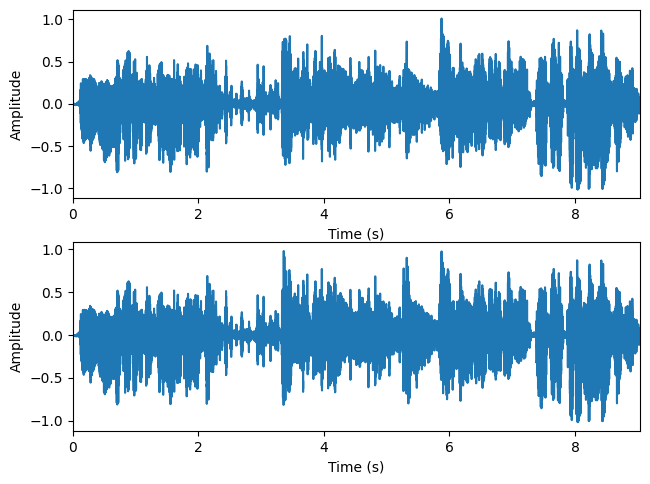

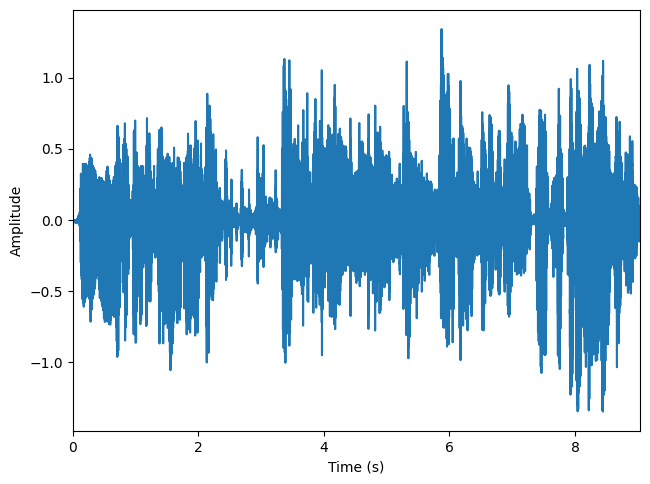

In [82]:
# plot waveforms - original
fo, ao = waveform(audioClip)
# resampled
f, a = waveform(resampledClip)

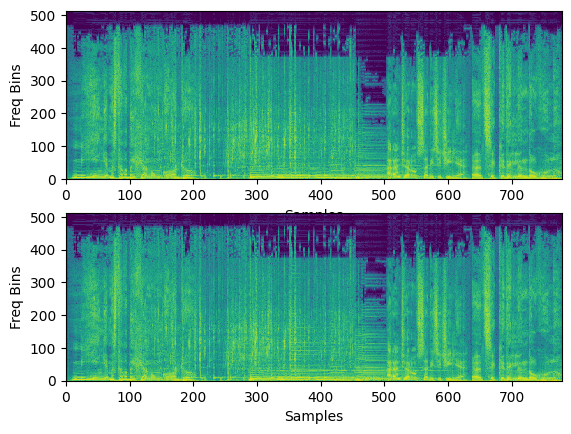

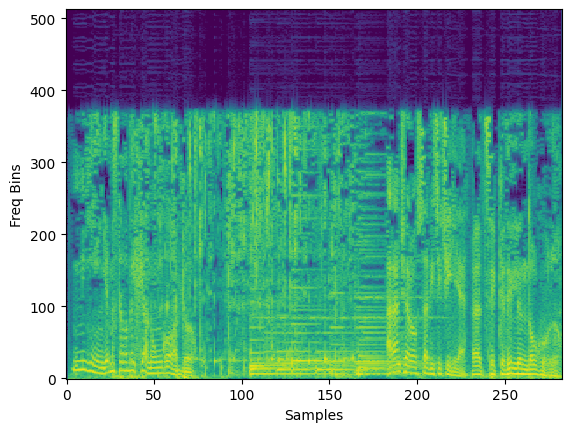

In [83]:
# Display Spectrum - original
smp, saxis = spectrum(audioClip, num_fft_bins=1024)

# resampled audio
rsmp, rsaxis = spectrum(resampledClip, num_fft_bins=1024)